# Обработка спаршенных 

In [2]:
!pip install requests beautifulsoup4

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
!pip install requests

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Парсинг сайта https://glavkniga.ru (не запускать)

In [130]:
import requests
from bs4 import BeautifulSoup as BS
import pandas as pd
#Создание ссылок для на каждую ленту
weeks_in_year = 52
pattern = "https://glavkniga.ru/news/?week="
week_number = "2"
links = []
begin_year = 2020
end_period = (41,2022)
for i in range(3):
  for j in range(weeks_in_year):
    if i+begin_year == end_period[1] and j == end_period[0]:
      break
    links.append(pattern+str(j)+'-' + str(begin_year+i))
  if i+begin_year == end_period[1]:
    break

article_links = []
for url in links:
  response = requests.get(url)
  soup = BS(response.text, 'lxml')
  for a in soup.find_all('a', {"class": "news_block_hdg"}):
      article_links.append('https://glavkniga.ru'+a['href'])

data = []
for url in article_links:
  response = requests.get(url)
  soup = BS(response.text, 'lxml')
  date = soup.find_all('div', id = 'news_flags_date')[0].text
  title = soup.find_all('h1')[0].text
  summery = soup.find_all('div', id = 'news_lead')[0].text
  text = ' '.join(soup.find_all('div', id="news_body")[0].text.split())
  data.append([title, text, date])

dataF = pd.DataFrame(data, columns = ['title', 'content', 'date'])
dataF.to_csv('data.csv')

# Обработка спаршенных данных

In [91]:
import pandas as pd
import numpy as np
from datetime import datetime
import re


In [92]:
import gdown
# Скачивание данных для обработки от Сани
url = 'https://drive.google.com/drive/folders/1sdsPQBmz2NunzABgYoy7asCS0IPSYDcN?usp=sharing'
folder_name = 'datasets_by_sasha'
gdown.download_folder(url, output=folder_name)

Retrieving folder list


Retrieving folder 12Wv913yC_aWejrCYHgXCZl3ggycYATZD Бухгалтеры
Processing file 123Bs0vcXt0qyO7rptacwBGp57Mon8wYT buh.csv
Retrieving folder 1OLo0jQ0_8gMAtgxpYQrWsw68S4vTRcEL ГенДиректора
Processing file 16GEZ6Ray2qEMhIuNbj8OkkkPxiPtnaGd avenuenews.csv
Processing file 1uLXmD4OTmRDGMNN_WCMsTk0kgWVAEoga economika.csv
Processing file 1X_O36FRtolRuc6Jk8zom0UL5SIzBaY7P mislinemisli.csv
Processing file 17jJQwXjV5DAEGI65CBRIIyQQSkrlrajn secretmag.csv
Processing file 12RawUV0LQc8mqtA1YGjU6jAT3kkX2xpw svoedelo.csv
Processing file 18kytmV4zlTG3AKXp6Vqaqp7eKLggUQEm tinkoffjournal.csv
Building directory structure completed


Retrieving folder list completed
Building directory structure
Downloading...
From: https://drive.google.com/uc?id=123Bs0vcXt0qyO7rptacwBGp57Mon8wYT
To: /content/datasets_by_sasha/Бухгалтеры/buh.csv
100%|██████████| 30.6M/30.6M [00:00<00:00, 315MB/s]
Downloading...
From: https://drive.google.com/uc?id=16GEZ6Ray2qEMhIuNbj8OkkkPxiPtnaGd
To: /content/datasets_by_sasha/ГенДиректора/avenuenews.csv
100%|██████████| 1.85M/1.85M [00:00<00:00, 139MB/s]
Downloading...
From: https://drive.google.com/uc?id=1uLXmD4OTmRDGMNN_WCMsTk0kgWVAEoga
To: /content/datasets_by_sasha/ГенДиректора/economika.csv
100%|██████████| 14.0M/14.0M [00:00<00:00, 246MB/s]
Downloading...
From: https://drive.google.com/uc?id=1X_O36FRtolRuc6Jk8zom0UL5SIzBaY7P
To: /content/datasets_by_sasha/ГенДиректора/mislinemisli.csv
100%|██████████| 15.1M/15.1M [00:00<00:00, 291MB/s]
Downloading...
From: https://drive.google.com/uc?id=17jJQwXjV5DAEGI65CBRIIyQQSkrlrajn
To: /content/datasets_by_sasha/ГенДиректора/secretmag.csv
100%|█████████

['datasets_by_sasha/Бухгалтеры/buh.csv',
 'datasets_by_sasha/ГенДиректора/avenuenews.csv',
 'datasets_by_sasha/ГенДиректора/economika.csv',
 'datasets_by_sasha/ГенДиректора/mislinemisli.csv',
 'datasets_by_sasha/ГенДиректора/secretmag.csv',
 'datasets_by_sasha/ГенДиректора/svoedelo.csv',
 'datasets_by_sasha/ГенДиректора/tinkoffjournal.csv']

In [93]:
#ссылки на папку загрузки обработанных данных
google_disk_dir_processed_accountant_path = '/content/drive/MyDrive/VTB hack/Обработанные данные/processed_бухгалтера/'
google_disk_dir_processed_ceo_path = '/content/drive/MyDrive/VTB hack/Обработанные данные/processed_директора/'

In [94]:
# Функции для преобразование колонки даты
def get_month(month_string):
  d = {'декабря':12,'января':1,'февраля':2,'марта':3,'апреля':4,'мая':5,'июня':6,'июля':7,'августа':8,'сентября':9,'октября':10,\
   'ноября':11}
  #if type(month_string) != 'str':
    #print(month_string)
  if type(month_string) is str:
    return d[month_string]
  else:
    return month_string
def convert(date_string_list):
  s = date_string_list
  return datetime.strptime(s[0] +'-'+ str(get_month(s[1])) +'-'+ s[2], '%d-%m-%Y')

# фильтрация контента по длине новости
def filter_contet_by_len(df, top_threshold = 700, bot_threshold = 100):
  mask_of_len = (df['content'].apply(str.split).apply(len) < top_threshold) & (df['content'].apply(str.split).apply(len) > bot_threshold)
  df = df.loc[mask_of_len,:]
  return df

#Сохранение только букв, цифр и знаков препинания
def clean_string(raw_html):
  CLEANR = re.compile("[^A-Za-z0-9А-Яа-я' ' '.' ',' '!' '?']")
  return re.sub(CLEANR, '', raw_html)


In [95]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
def plot_lengths_hist(series_of_content, xtick = np.arange(0,6000,250) ):
  #sns.histplot(data = series_of_content.apply(lambda x: len(str(x).split())) )
  plt.figure(figsize=(35,20))
  plt.hist(series_of_content.apply(lambda x: len(str(x).split())), bins = 'auto')
  plt.xticks(xtick)
  plt.show()

# Обработка гендиректоров

## secretmag

In [96]:
df = pd.read_csv('/content/datasets_by_sasha/ГенДиректора/secretmag.csv')
df = df.dropna()
df.loc[:, 'content'] = df.loc[:, 'content'].apply(clean_string)
df.loc[:, 'title'] = df.loc[:, 'title'].apply(clean_string)

In [97]:
df.loc[:,'date'] = df['date'].apply(str.split).apply(lambda x: x[1:]).apply(convert)

In [98]:
df.loc[:,'content'] = df['content'].apply(lambda x: x[:x.find('Коллаж:')])
df.loc[:, 'content'] = df['content'].apply(lambda x: x[:x.find('Фото:')])

In [99]:
df = filter_contet_by_len(df)

In [100]:
df['content'].apply(lambda x: len(x.split())).sort_values()

763     130
217     131
1011    137
1009    139
423     139
       ... 
154     664
631     668
1057    670
634     677
72      693
Name: content, Length: 515, dtype: int64

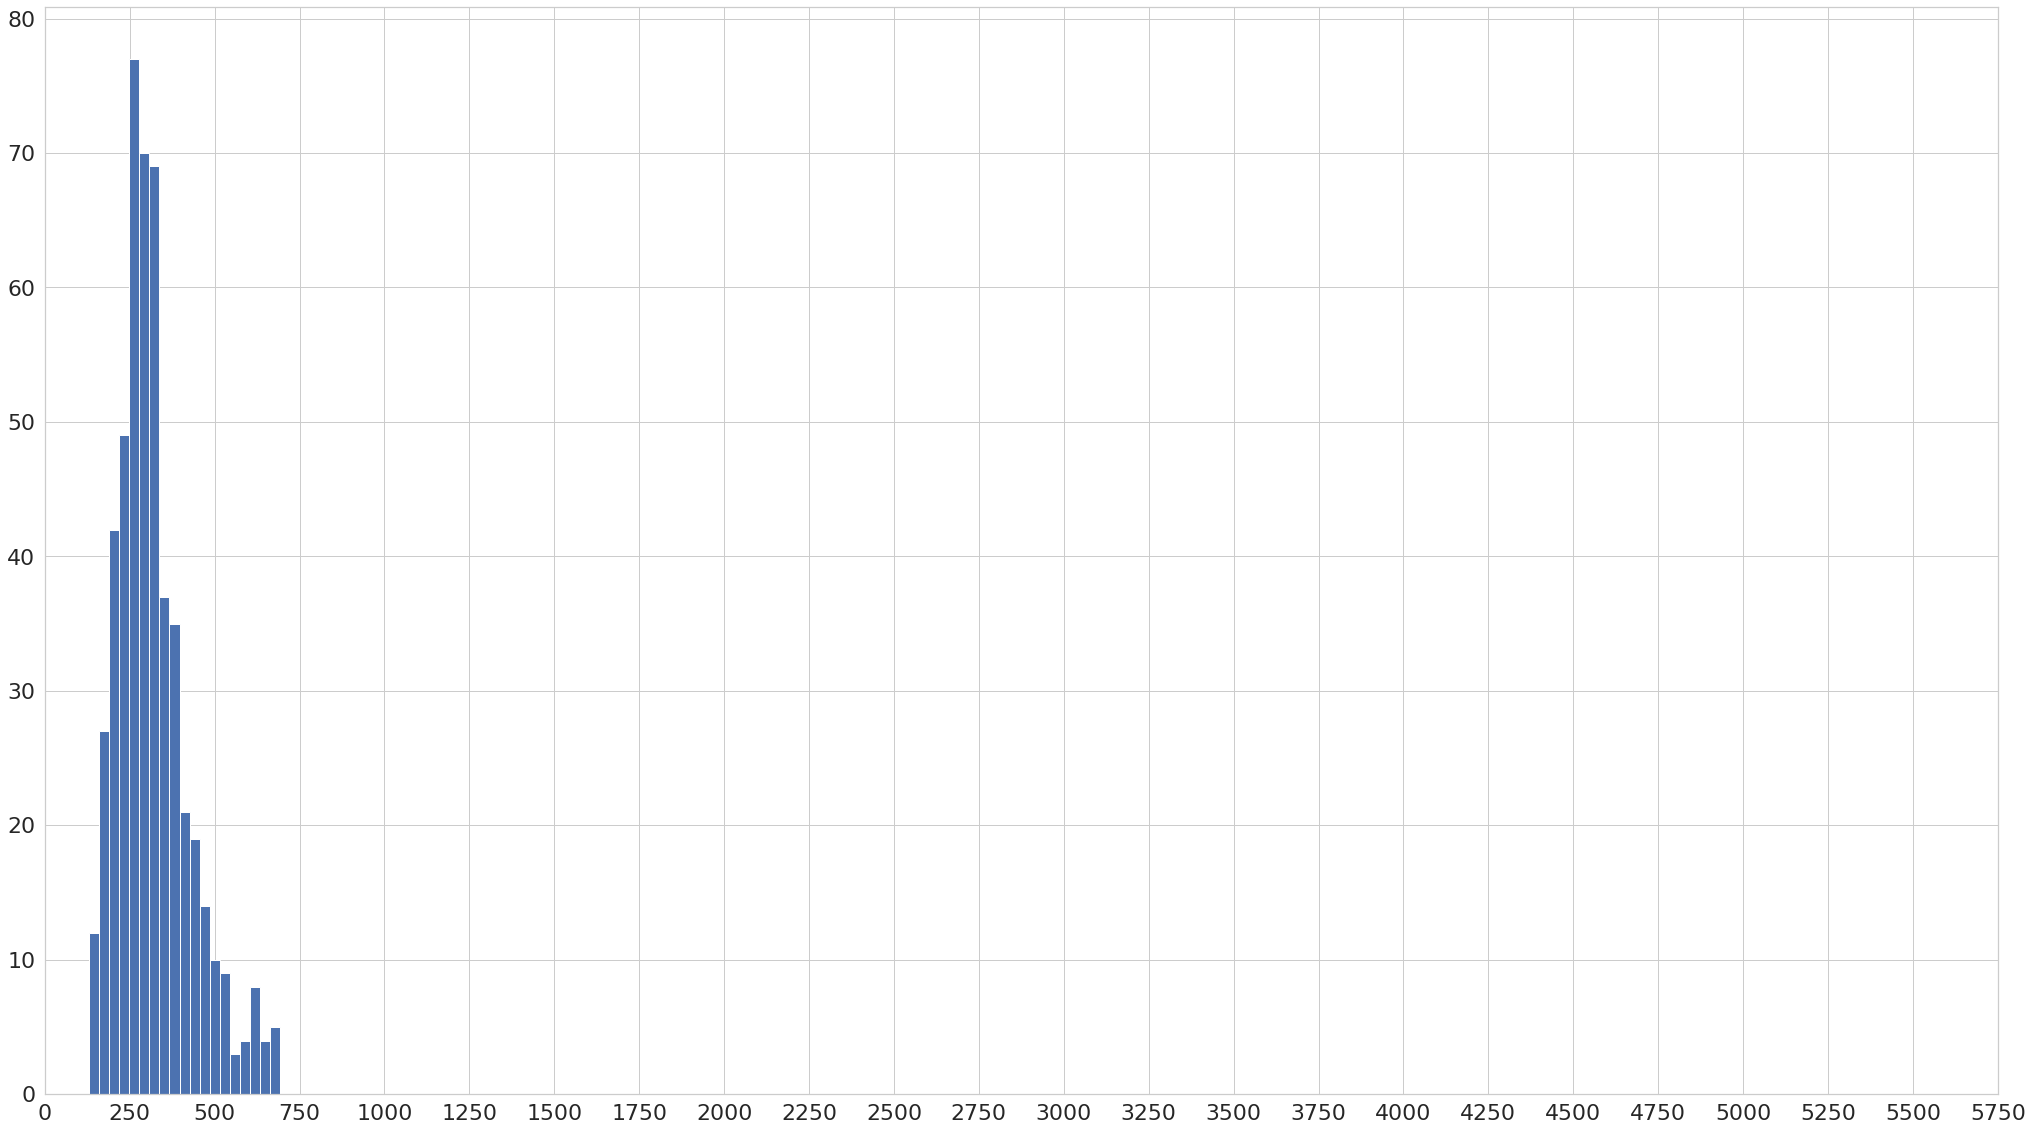

In [101]:
plot_lengths_hist(df['content'])

In [102]:
df.to_csv(google_disk_dir_processed_ceo_path + 'secretmag_processed.csv')

## tinkoffjournal

In [103]:
df = pd.read_csv('/content/datasets_by_sasha/ГенДиректора/tinkoffjournal.csv')
df = df.dropna()
df.loc[:, 'content'] = df.loc[:, 'content'].apply(clean_string)
df.loc[:, 'title'] = df.loc[:, 'title'].apply(clean_string)

In [104]:
df.loc[:,'date'] = pd.to_datetime(df['date'], format = '%d.%m.%y')


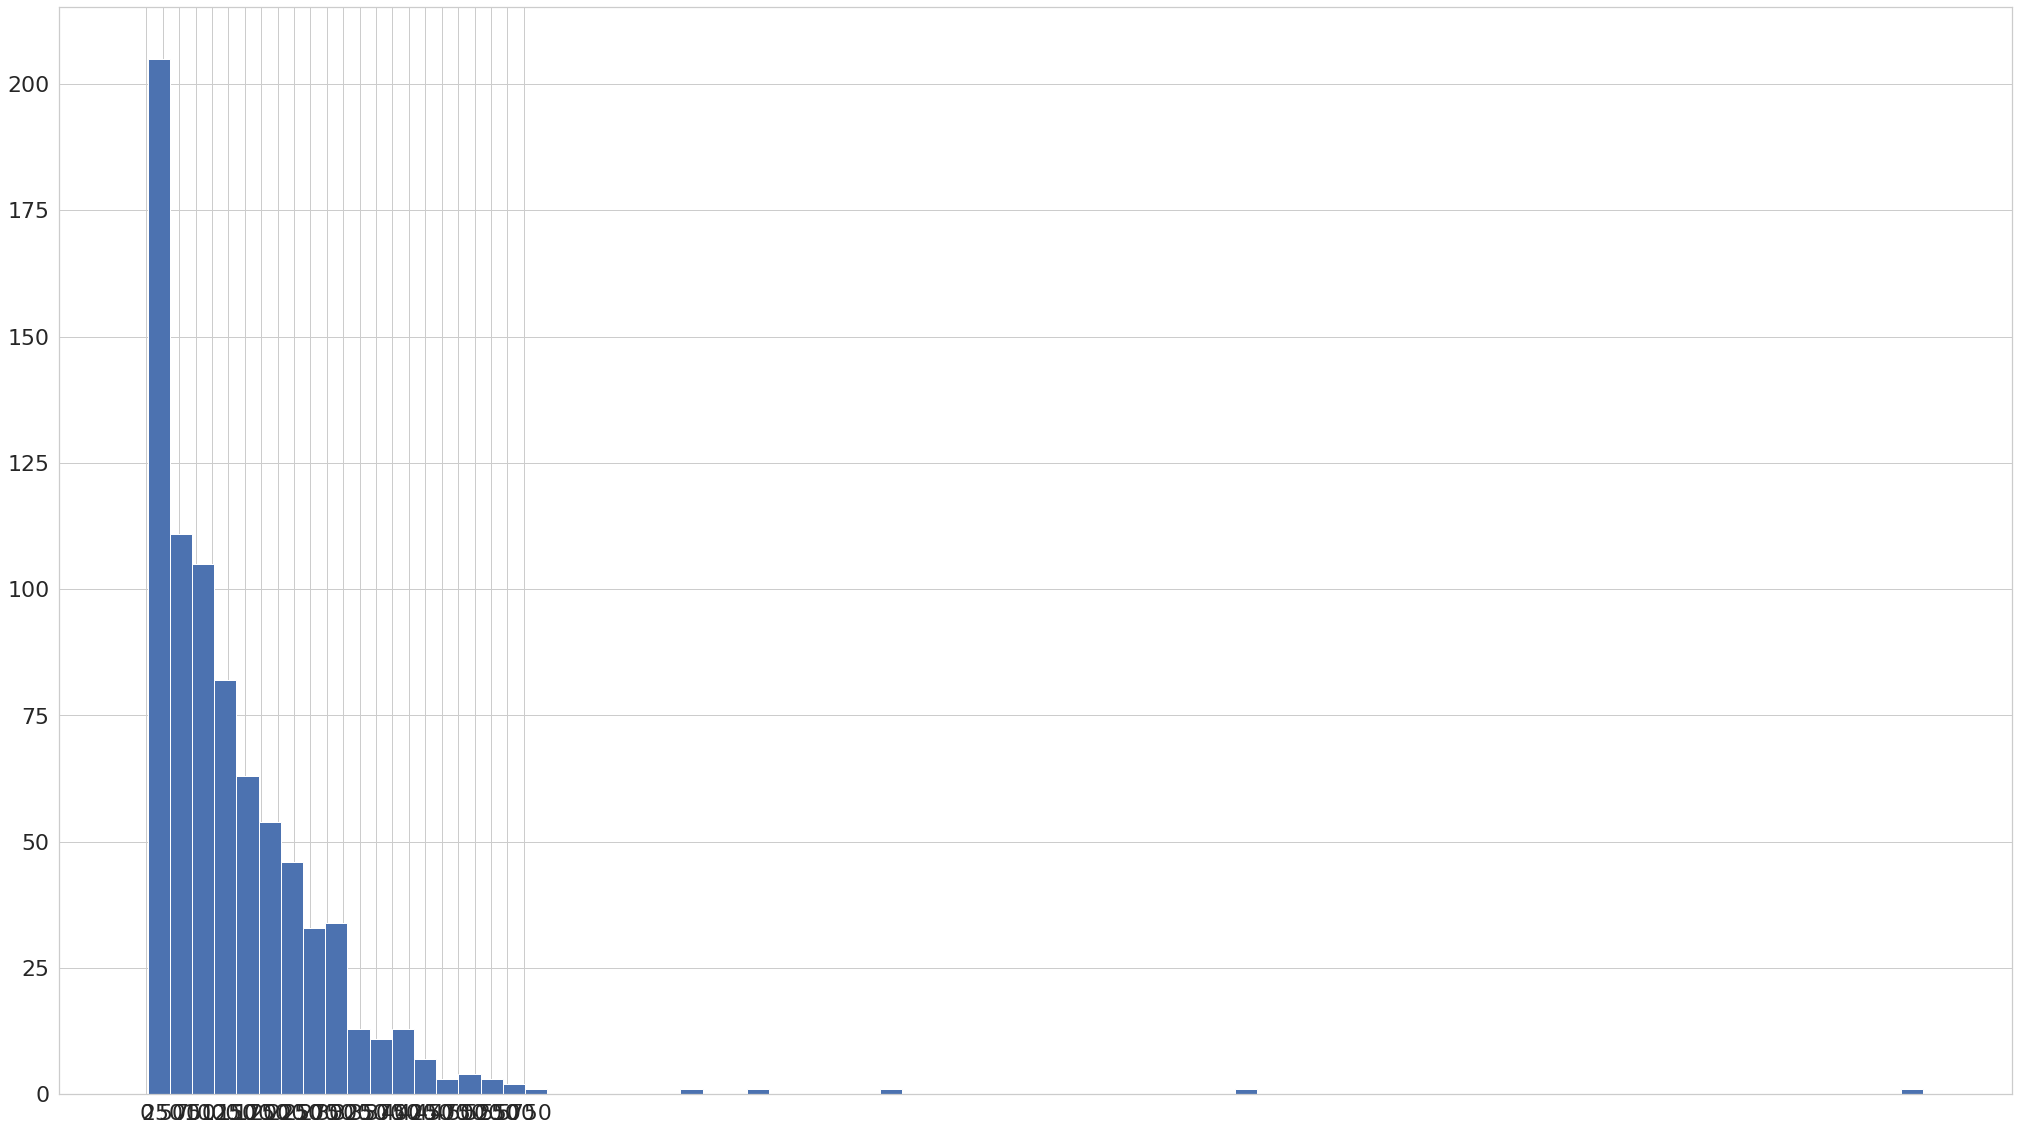

In [105]:
plot_lengths_hist(df['content'])

In [106]:
mask_subscribe = df['content'].apply(lambda x : 'Подписывайтесь' in x)

In [107]:
df.loc[:, 'content'] = df['content'].apply(lambda x: x[:x.find('Подписывайтесь')])
df = filter_contet_by_len(df)

In [108]:
df.loc[:, 'content'].apply(lambda x: len(x.split())).sort_values()

456    101
750    102
271    102
143    102
514    103
      ... 
248    687
643    688
739    689
35     690
123    694
Name: content, Length: 230, dtype: int64

In [109]:
df.loc[456, 'content']

'Инстаграм выпустил обновление для бизнесаккаунтов вприложении появился раздел сподборками продвигаемых постов отпохожих аккаунтов.Тоесть можно посмотреть, какие посты рекламируют конкуренты.Как попасть вновый раздел. Нужно обновить приложение, зайти вовкладку спрофилем, нажать накнопку Посмотреть профессиональные ресурсы наверху. После нажать наКак компании находят клиентов.Источник Инстаграм Откроется раздел сдвумя подборкамиНакаждый пост можно нажать, посмотреть, как онвыглядит вленте исколько набрал лайков икомментариев отпользователей.Создатели сервиса считают, что новый инструмент поможет бизнесаккаунтам увидеть, как похожие проекты развиваются ивзаимодействуют спользователями. Комуто это может помочь найти вдохновение, чтобы создавать ирекламировать свой контент. Кроме того, Инстаграм расширил раздел статистики теперь вбизнесаккаунтах иаккаунтах авторов можно изучить данные запрошедшие 60дней, анеза30, как было раньше'

In [110]:
df.to_csv(google_disk_dir_processed_ceo_path + 'tinkoffjournal_processed.csv')

## mislinemisli tg

In [111]:
df = pd.read_csv('/content/datasets_by_sasha/ГенДиректора/mislinemisli.csv', index_col=[0])
df = df.dropna()
df.loc[:, 'content'] = df.loc[:, 'content'].apply(clean_string)
df.loc[:, 'title'] = df.loc[:, 'title'].apply(clean_string)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1951: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[selected_item_labels] = value


In [112]:
df.loc[:, 'date'] = pd.to_datetime(df['date'].apply(lambda x: x.split(' ')[0]))

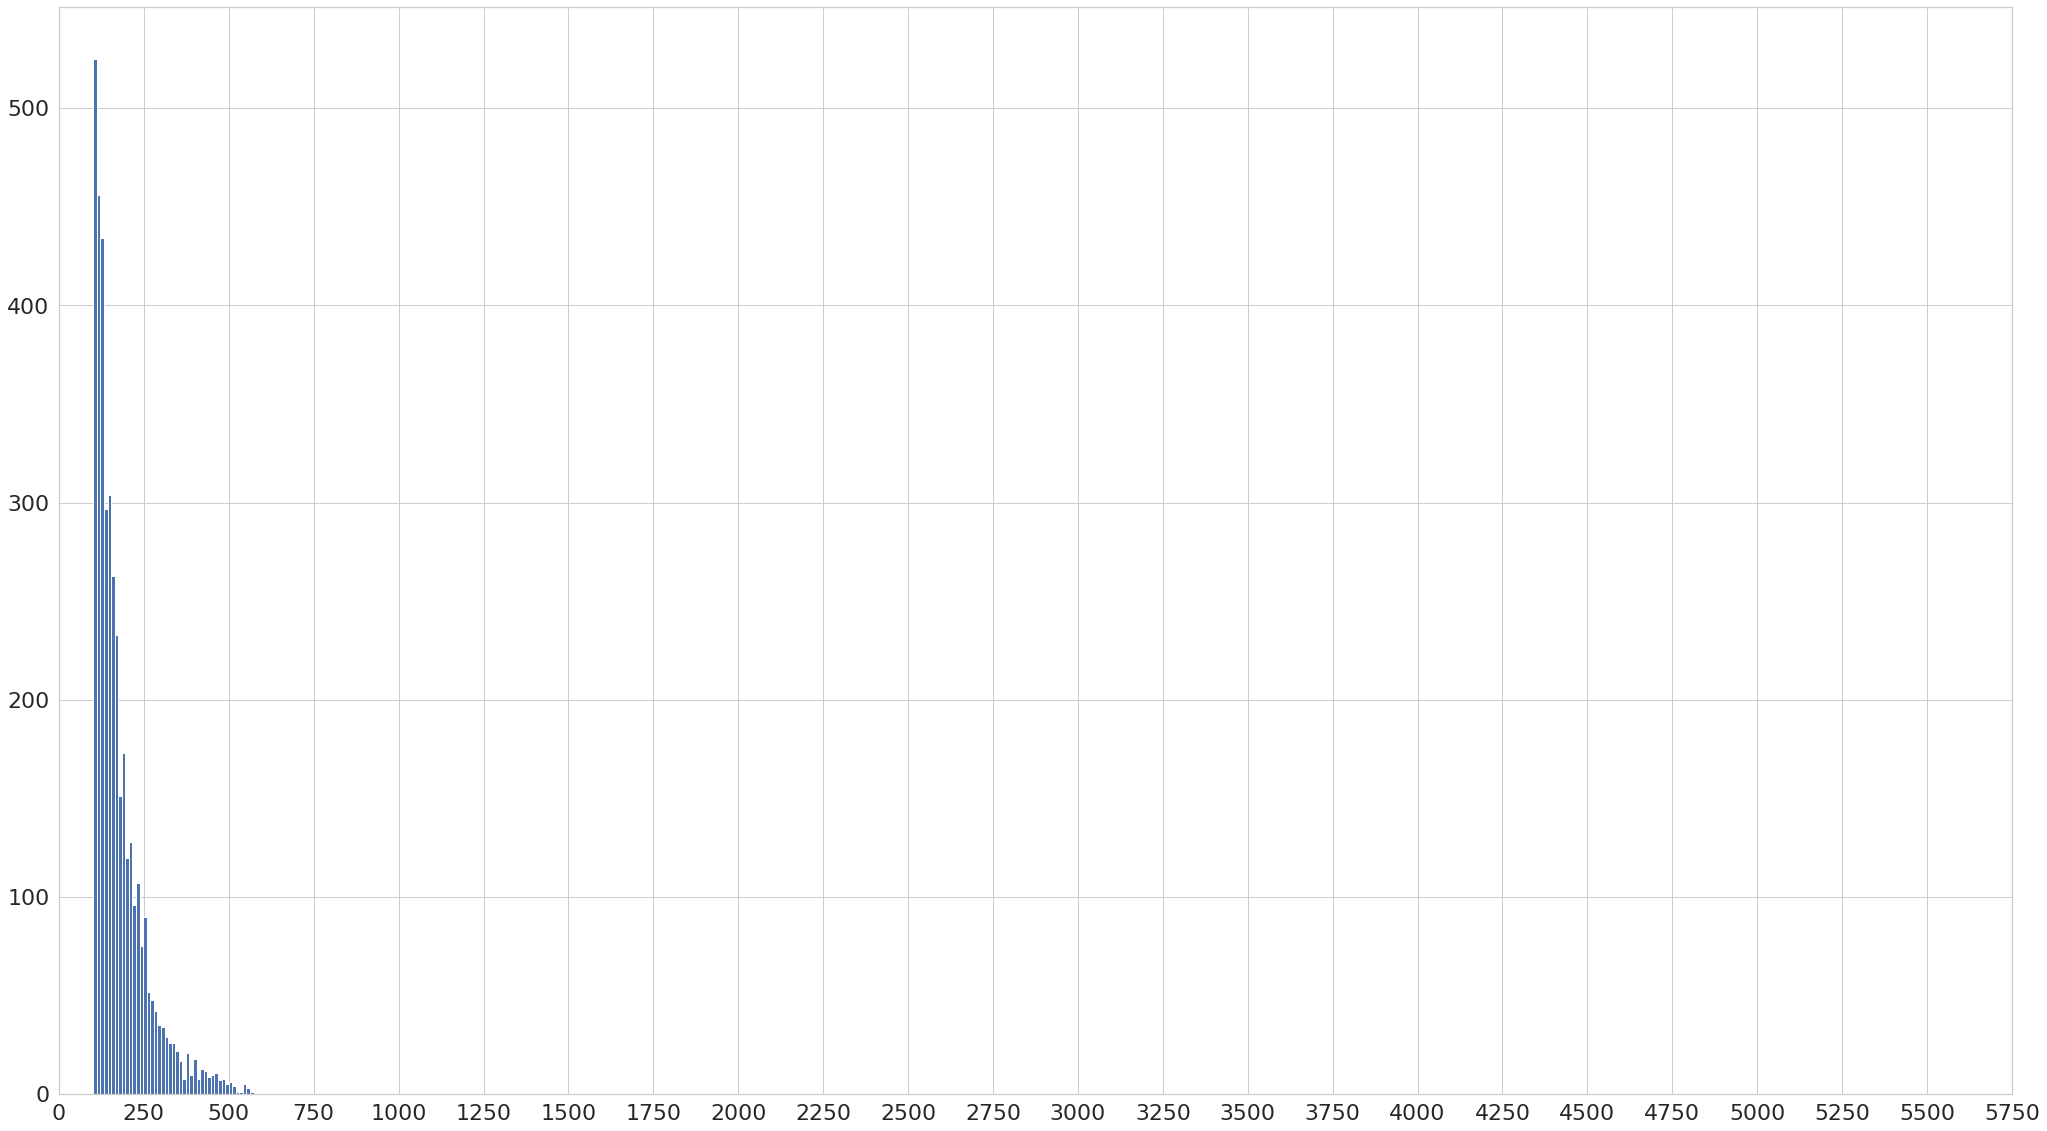

In [113]:
df = filter_contet_by_len(df)
plot_lengths_hist(df['content'])

In [114]:
df.to_csv(google_disk_dir_processed_ceo_path + 'mislinemisli_processed_tg.csv')

## economika tg

In [115]:
df = pd.read_csv('/content/datasets_by_sasha/ГенДиректора/economika.csv', index_col=[0])
df = df.dropna()
df.loc[:, 'content'] = df.loc[:, 'content'].apply(clean_string)
df.loc[:, 'title'] = df.loc[:, 'title'].apply(clean_string)

In [116]:
df.loc[:, 'date'] = pd.to_datetime(df['date'].apply(lambda x: x.split(' ')[0]))

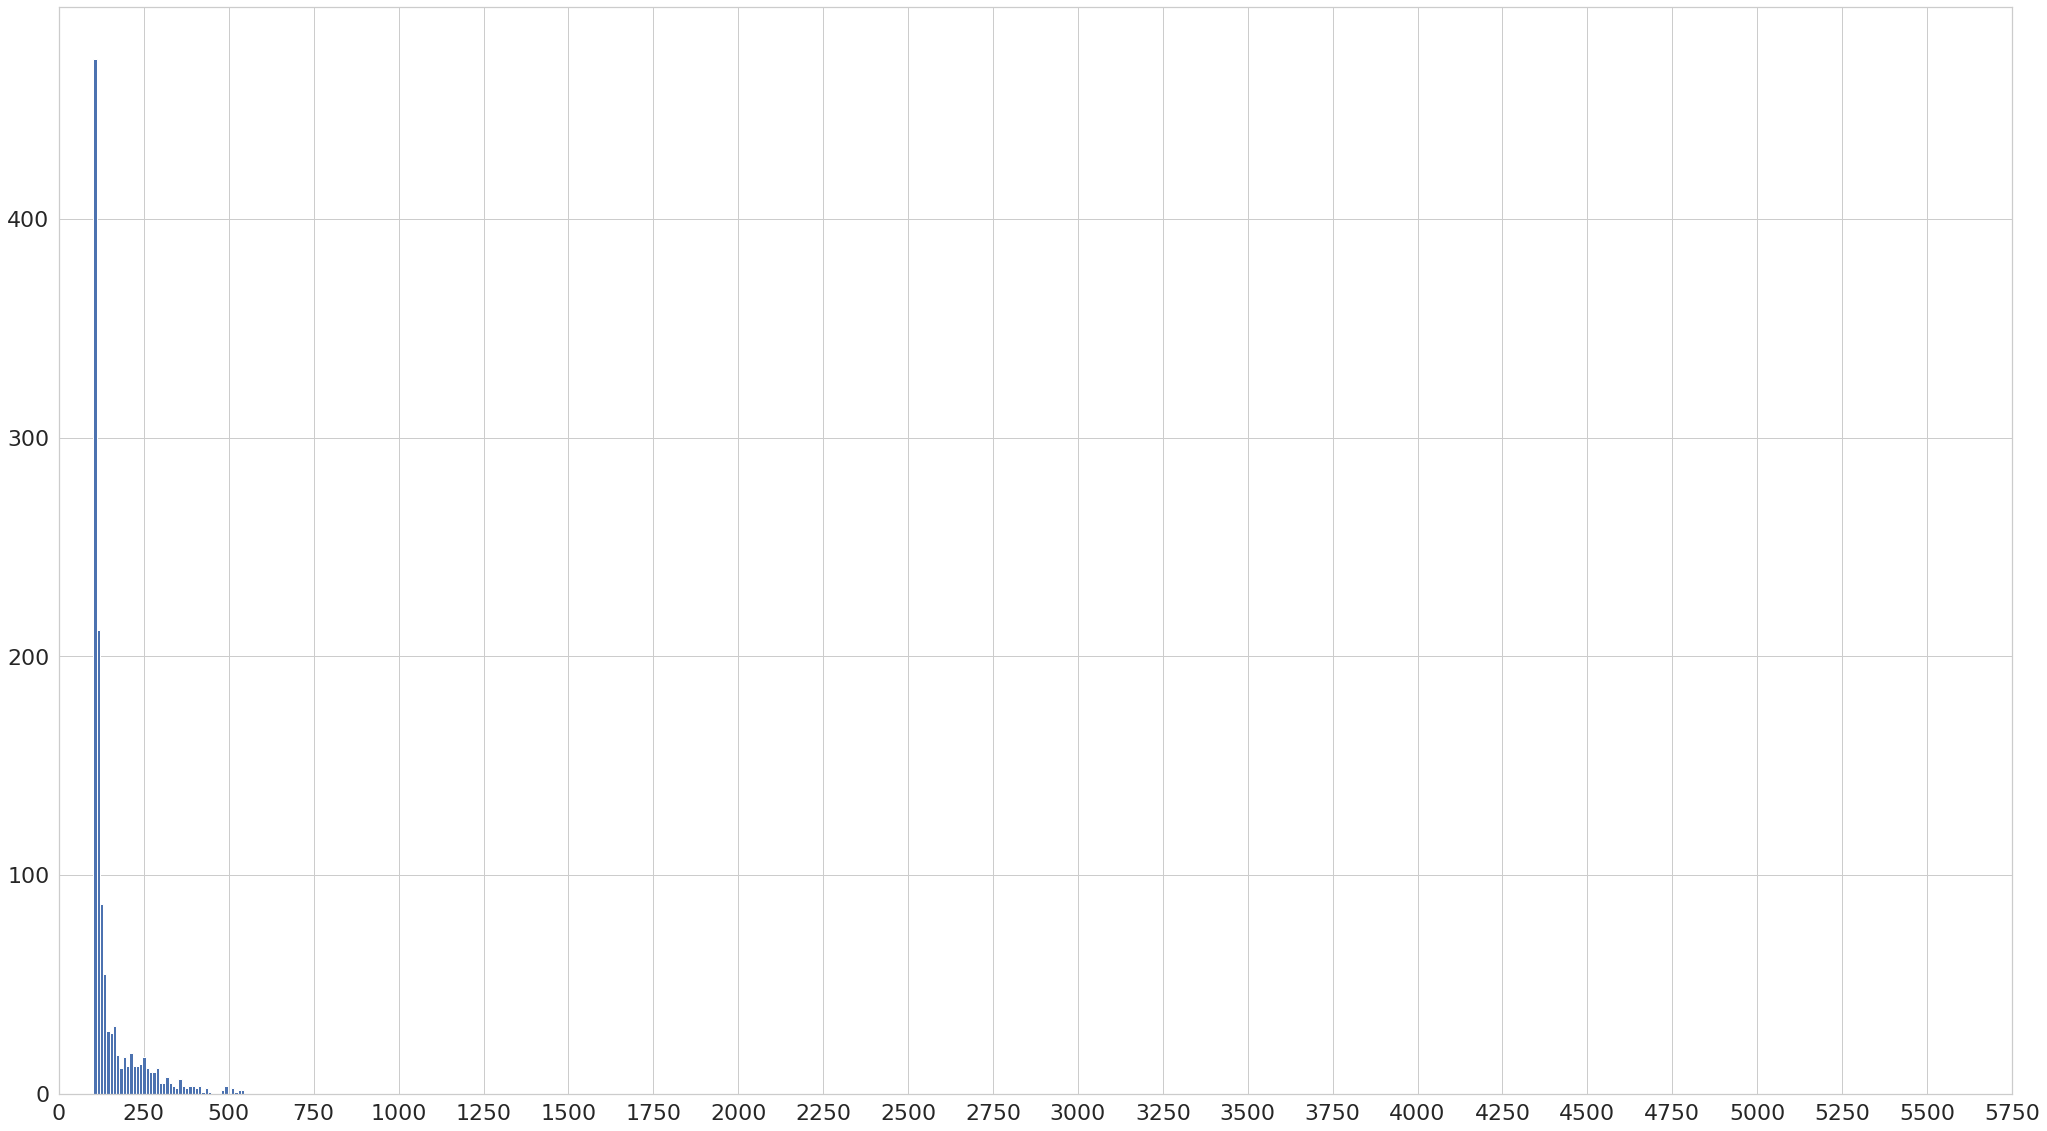

In [117]:
df = filter_contet_by_len(df)
plot_lengths_hist(df['content'])


In [118]:
df['content'].apply(lambda x: len(x.split())).sort_values()

9996    101
4045    101
8281    101
3770    101
8565    101
       ... 
7175    521
4149    526
372     527
3574    541
5506    545
Name: content, Length: 1173, dtype: int64

In [119]:
df['content'].apply(lambda x: x).loc[4045]

'Я исхожу из того, что в следующий газовый год мы войдем с относительно низким уровнем объема газа в хранилищах, поэтому на эту зиму я бы поставил на высокие цены на газ, я думаю, они сохранятся,  сказал он.По его словам, рекордный уровень цен на газ даже летом объясняется аномально низкими температурами в начале 2021 года. Вопервых, это была необычно холодная зима. Даже в апреле и мае температуры были на самом низком уровне за последние 3040 лет. И именно поэтому, кстати говоря, текущие объемы газа в хранилищах меньше объемов прошлых лет. У нас было на один месяц меньше для заполнения хранилищ,  отметил Зеле.'

In [120]:
df.to_csv(google_disk_dir_processed_ceo_path + 'economika_processed_tg.csv')

## svoedelo

In [121]:
df = pd.read_csv('/content/datasets_by_sasha/ГенДиректора/svoedelo.csv')
df = df.dropna()
df.loc[:, 'content'] = df.loc[:, 'content'].apply(clean_string)
df.loc[:, 'title'] = df.loc[:, 'title'].apply(clean_string)

In [122]:
df.loc[:, 'date'] = pd.to_datetime(df['date'])

In [123]:
df = filter_contet_by_len(df, top_threshold = 700)

In [124]:
df.loc[:, 'content'] = df['content'].apply(lambda x: x.replace('liliaagarkova17gmail.com', ' '))

In [125]:
df.to_csv(google_disk_dir_processed_ceo_path + 'svoedelo_processed.csv')

## avenuenews tg

In [126]:
df = pd.read_csv('/content/datasets_by_sasha/ГенДиректора/avenuenews.csv', index_col=[0])
df = df.dropna()
df.loc[:, 'content'] = df.loc[:, 'content'].apply(clean_string)
df.loc[:, 'title'] = df.loc[:, 'title'].apply(clean_string)

In [127]:
df.loc[:, 'date'] = pd.to_datetime(df['date'].apply(lambda x: x.split()[0]))

In [128]:
df = filter_contet_by_len(df)

In [129]:
df.to_csv(google_disk_dir_processed_ceo_path + 'avenuenews_processed_tg.csv')

# Обработка бухгалтеров

In [ ]:
url = 'https://drive.google.com/drive/folders/1MaeTquVZHQvNhezZXT5tQKY9OeG8Lm72?usp=sharing'
folder_name = 'Данные_для_обработки'
gdown.download_folder(url, output=folder_name)

## buh

In [131]:
df = pd.read_csv('/content/datasets_by_sasha/Бухгалтеры/buh.csv')
df = df.dropna()
df.loc[:, 'content'] = df.loc[:, 'content'].apply(clean_string)
df.loc[:, 'title'] = df.loc[:, 'title'].apply(clean_string)

In [132]:
df.loc[:, 'date'] = pd.to_datetime(df['date'])

In [133]:
df.loc[:, 'content'] = df['content'].apply(lambda x: x[:x.find('Следить за новостями удобно в нашем')])

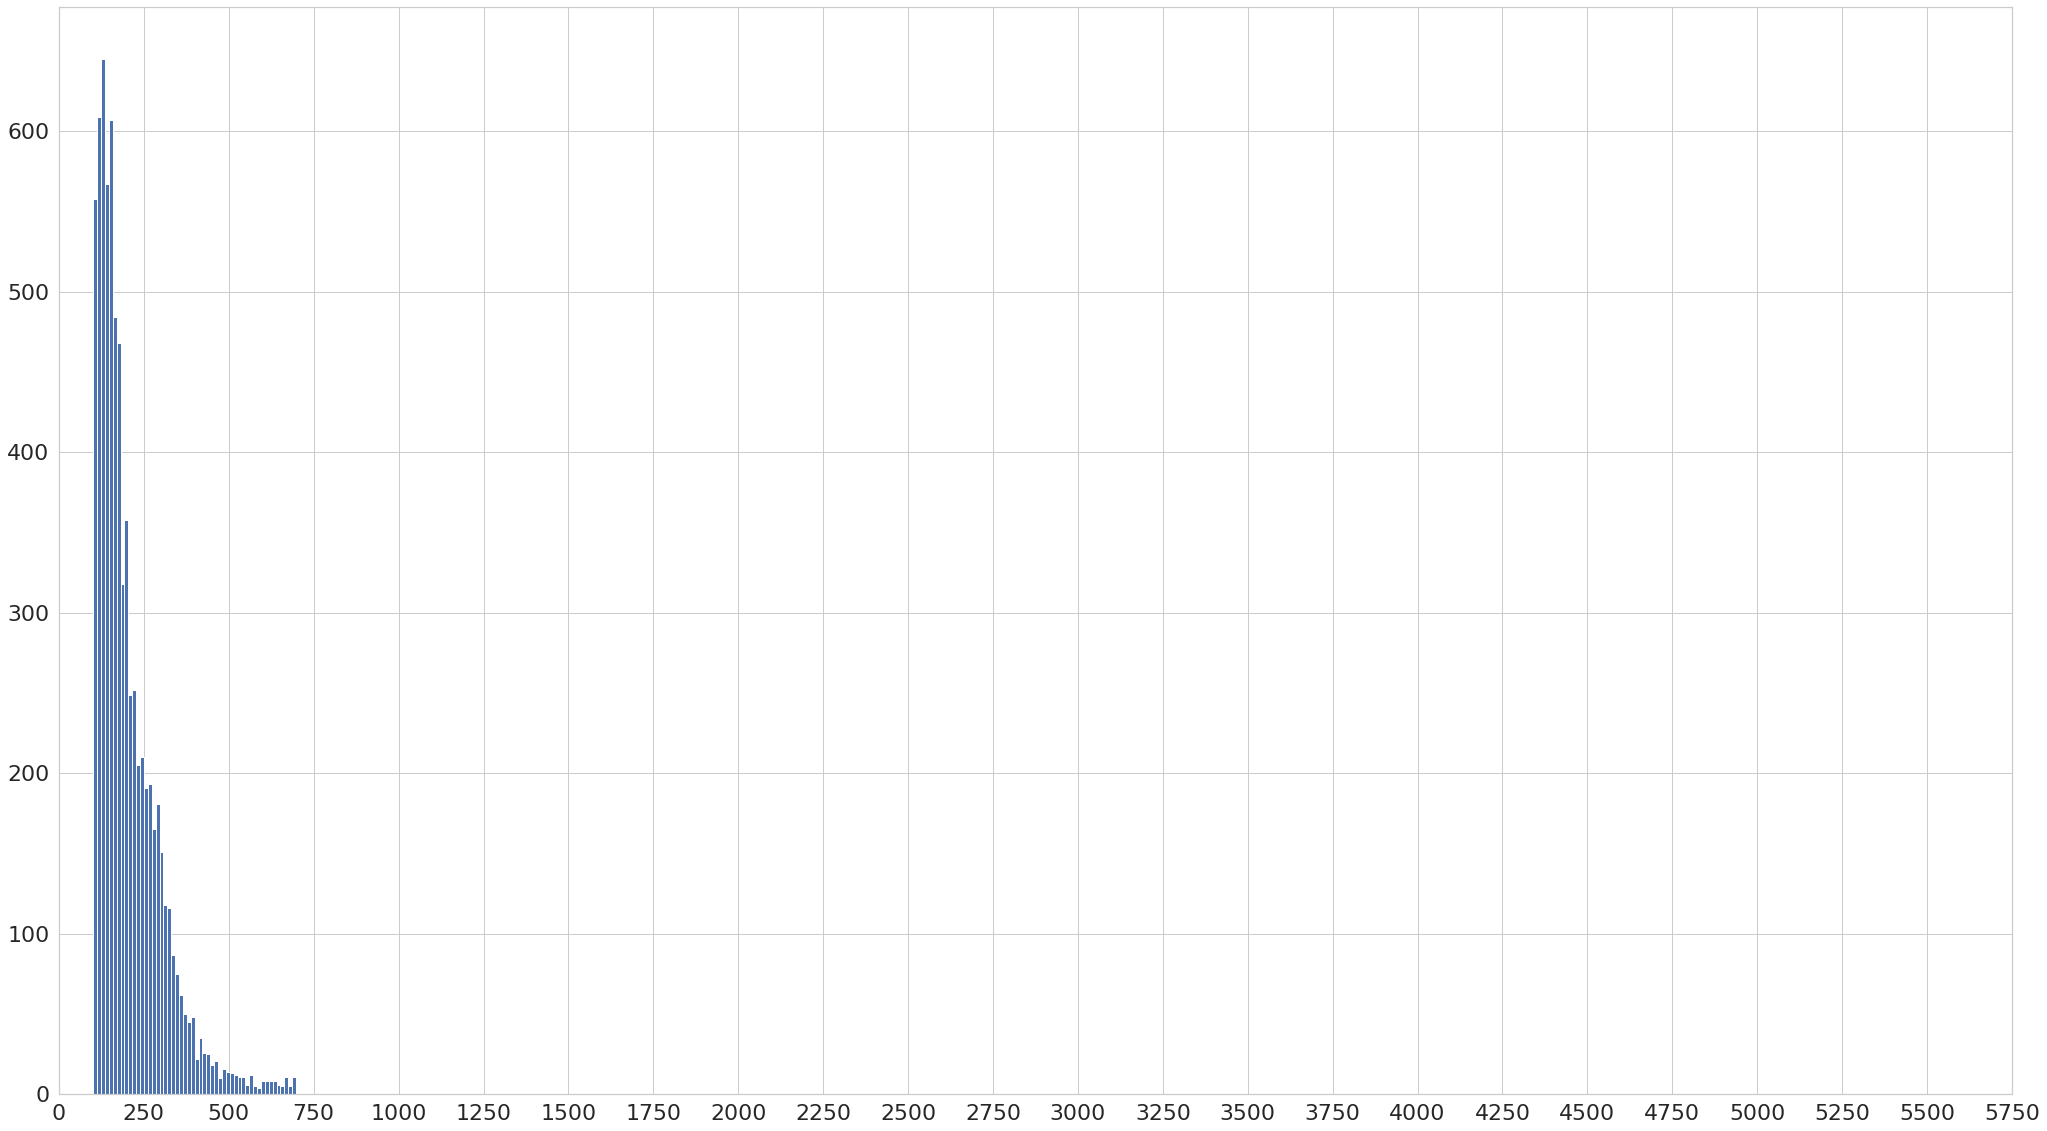

In [134]:
df = filter_contet_by_len(df)
plot_lengths_hist(df['content'])

In [135]:
df.to_csv(google_disk_dir_processed_accountant_path + 'buh_processed.csv')

## glavkniga

In [136]:
full_df = pd.read_csv('/content/Данные_для_обработки/data_from_glavkniga_2part.csv', index_col = 0)
full_df = full_df.dropna()
full_df.loc[:, 'content'] = full_df.loc[:, 'content'].apply(clean_string)
full_df.loc[:, 'title'] = full_df.loc[:, 'title'].apply(clean_string)

#Обработка поля date
mask_of_bad_date = full_df['date'].apply(str.split).apply(len) == 2
full_df.loc[mask_of_bad_date,'date'] = full_df[mask_of_bad_date]['date'].apply(lambda x : x + ' ' + str(2022))
full_df.loc[:,'date'] = full_df['date'].apply(str.split).apply(convert)

# Удаление мусорных слов в конце новости
full_df.loc[:,'content'] = full_df['content'].apply(lambda x: x[:x.find('письмо', len(x)-80)])
full_df.loc[:,'content'] = full_df['content'].apply(lambda x: x[:x.find('Письмо', len(x)-80)])
full_df.loc[:,'content'] = full_df['content'].apply(lambda x: x[:x.find('читайте в', len(x)-80)])

full_df = filter_contet_by_len(full_df)
full_df.to_csv(google_disk_dir_processed_accountant_path + 'data_from_glavkniga_processed.csv') 

## mytar tg

In [137]:
df = pd.read_csv('/content/Данные_для_обработки/mytar.csv', index_col = [0])
df = df.dropna()
df.loc[:, 'content'] = df.loc[:, 'content'].apply(clean_string)
df.loc[:, 'title'] = df.loc[:, 'title'].apply(clean_string)

In [138]:
df.loc[:, 'date'] = pd.to_datetime(df['date'].apply(lambda x: x.split()[0]))

In [139]:
df = filter_contet_by_len(df)

In [140]:
df.to_csv(google_disk_dir_processed_accountant_path + 'mytar_processed_tg.csv')

## netipichniy_buh tg

In [141]:
df = pd.read_csv('/content/Данные_для_обработки/netipichniy_buh_final.csv', index_col = [0])
df = df.dropna()
df.loc[:, 'content'] = df.loc[:, 'content'].apply(clean_string)
df.loc[:, 'title'] = df.loc[:, 'title'].apply(clean_string)

In [142]:
df.loc[:, 'date'] = pd.to_datetime(df['date'].apply(lambda x: x.split()[0]))

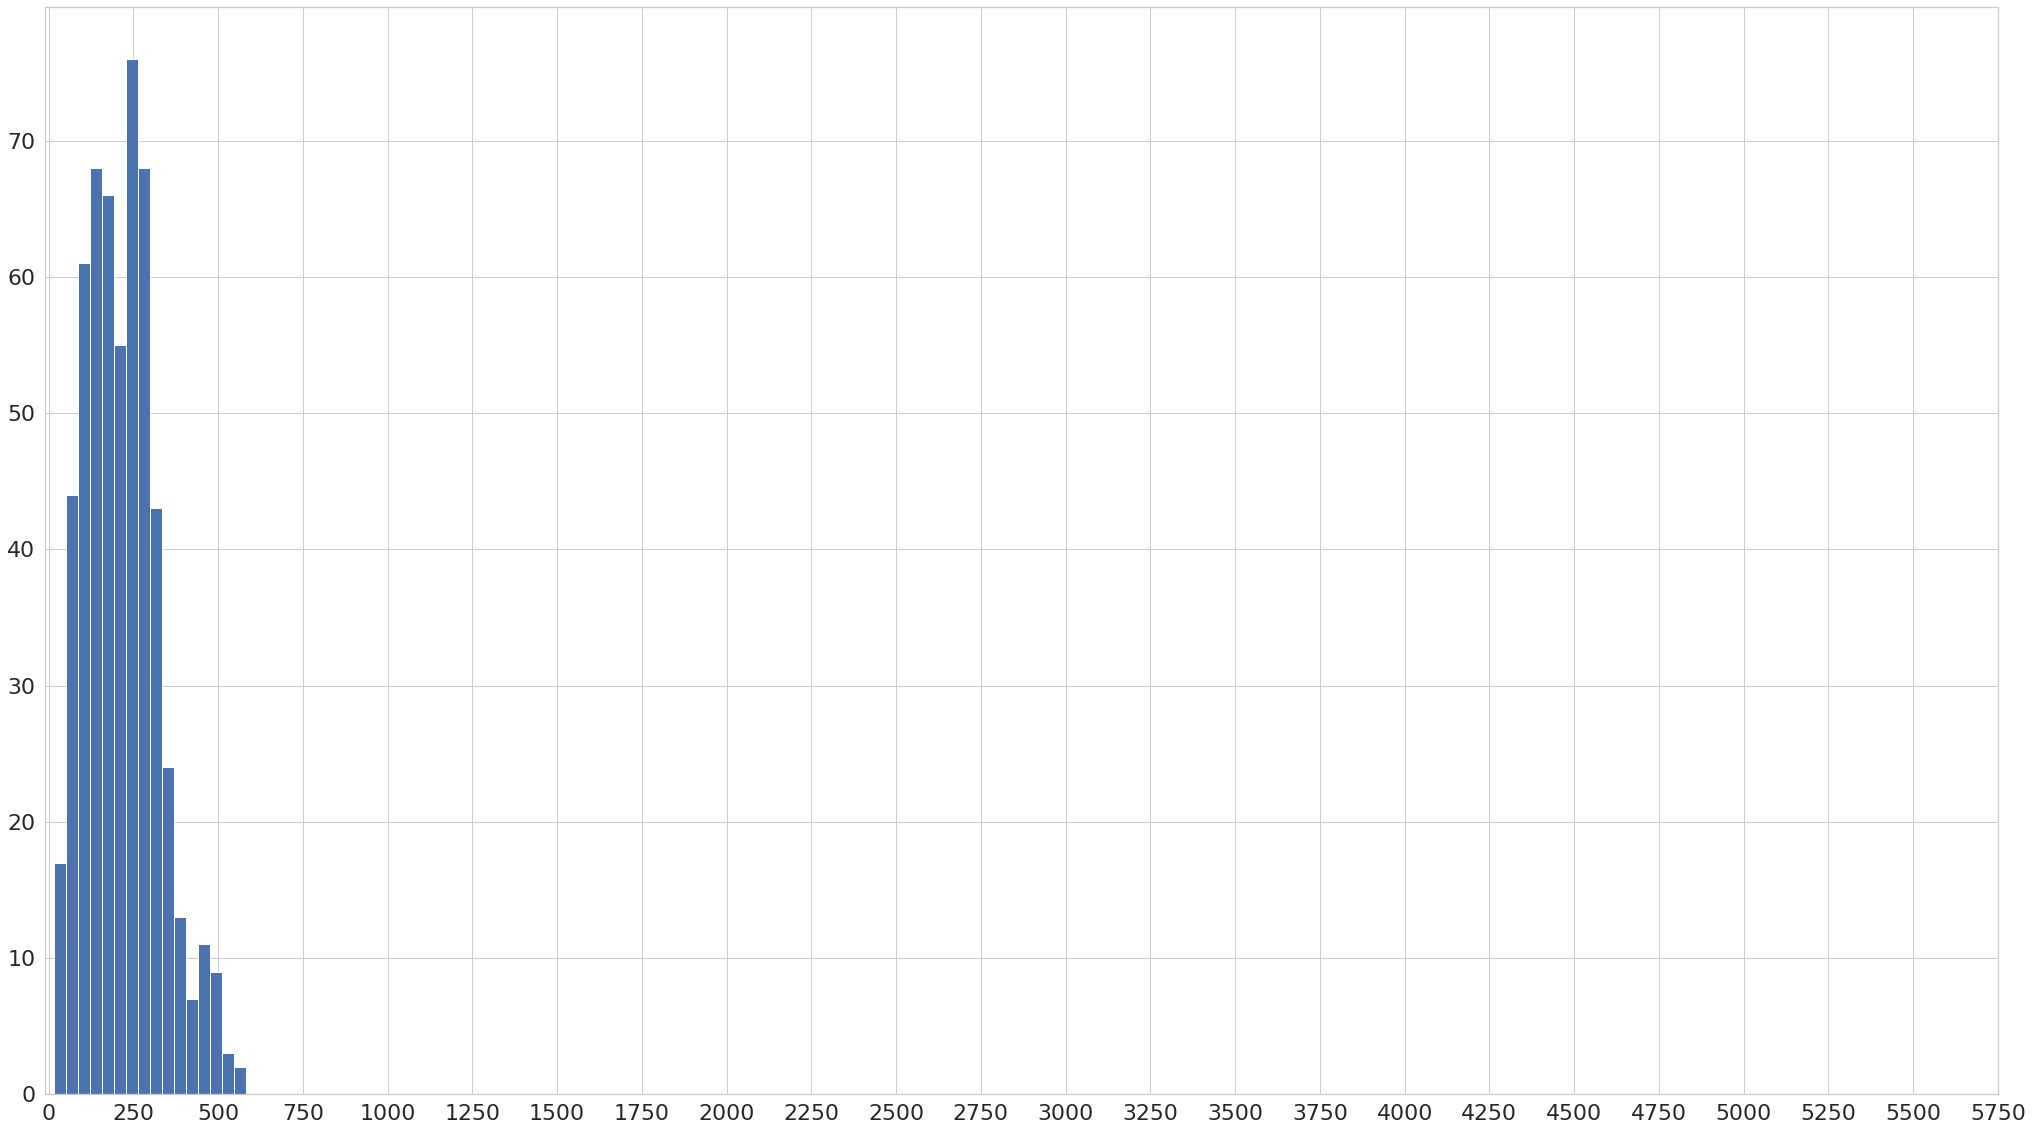

In [143]:
plot_lengths_hist(df['content'])

In [144]:
df = filter_contet_by_len(df)

In [145]:
df.to_csv(google_disk_dir_processed_accountant_path + 'netipichniy_buh_final_processed_tg.csv')

# Функция выдачи от временнного отрезка

In [4]:
def get_data_by_period(df, left_data_string = None, right_data_string = None):
  df.loc[:, 'date'] = pd.to_datetime(df['date'])
  mask = (df['date'] > pd.to_datetime(left_data_string)) & (df['date'] < pd.to_datetime(right_data_string))
  return df.loc[mask,:]

# Закачка всех processed данных

In [ ]:
import gdown
url = 'https://drive.google.com/drive/folders/1Tt1TFPPicXWx6PvWSKJcgtsZ2V2Z0sA0?usp=sharing'
folder_name = 'datasets_processed_by_Roma'
gdown.download_folder(url, output=folder_name)

In [148]:
import os
def get_concated_df(dir_path_to_merge):
  csv_s = [i for i in os.listdir(dir_path_to_merge) if '.csv' in i]
  csv_paths = []
  for filename in csv_s:
    csv_paths.append(os.path.join(dir_path_to_merge, filename))
  dfs_to_concat = []
  for i in csv_paths:
    dfs_to_concat.append(pd.read_csv(i, index_col = [0]))
  concated_df = pd.concat(dfs_to_concat, axis = 0)
  return concated_df

In [155]:
ceo_dir = '/content/datasets_processed_by_Roma/processed_директора'
acc_dir = '/content/datasets_processed_by_Roma/processed_бухгалтера'

## Concat и отправка директоров

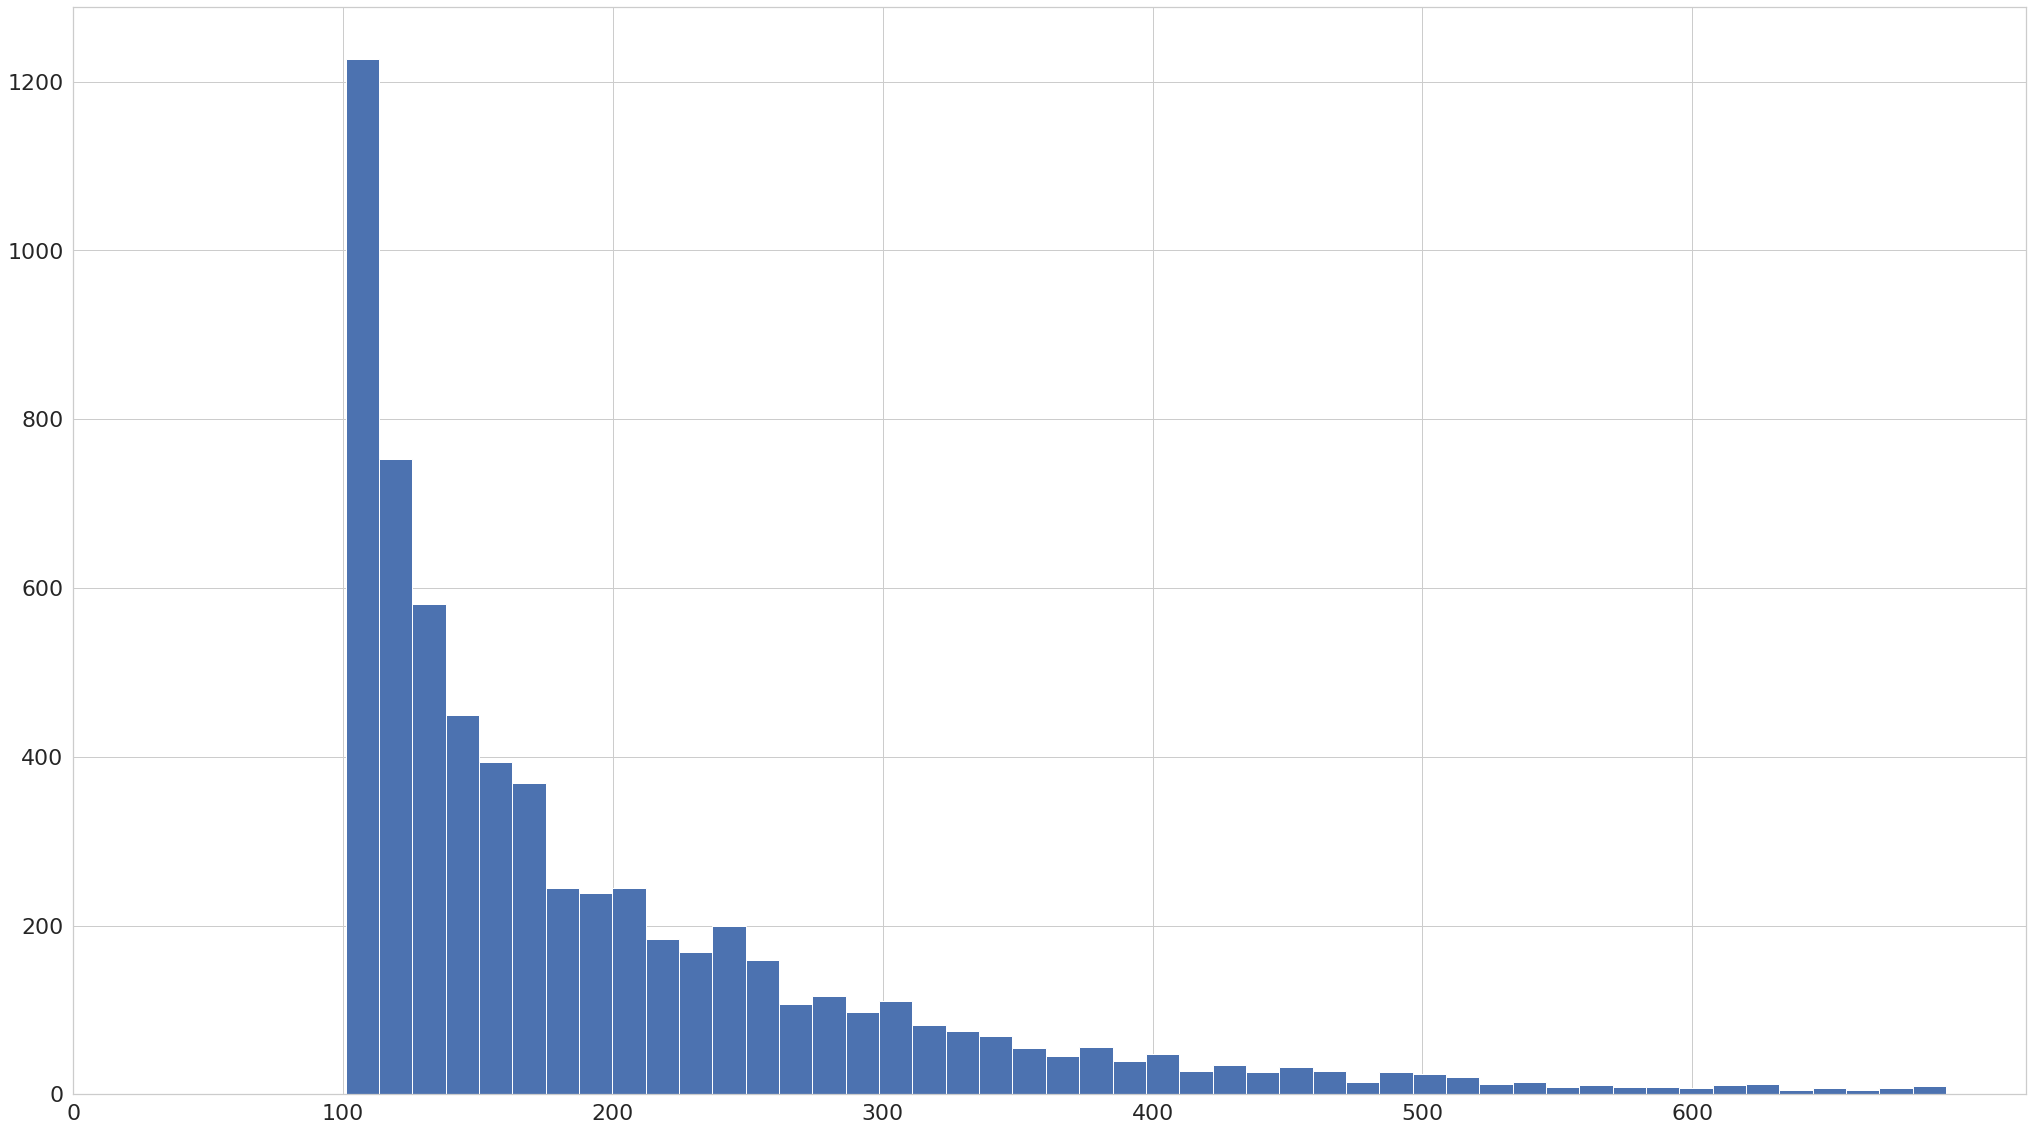

In [156]:
ceo_df_concated = get_concated_df(ceo_dir)
plot_lengths_hist(ceo_df_concated['content'], xtick = np.arange(0,700,100))

In [157]:
ceo_df_concated.loc[:, 'date'] = pd.to_datetime(ceo_df_concated['date'])

In [158]:
ceo_df_concated['content'].drop_duplicates(inplace = True)
ceo_df_concated.drop_duplicates(inplace = True)

In [159]:
ceo_df_concated = ceo_df_concated.dropna()
ceo_df_concated.isna().sum()

title      0
content    0
date       0
dtype: int64

In [160]:
ceo_df_concated.loc[:, 'content'] = ceo_df_concated['title'] + ' ' + ceo_df_concated['content']


In [161]:
ceo_df_concated.to_csv('/content/drive/MyDrive/VTB hack/ceo_data_processed.csv')

## Concat и отправка бухгалтеров

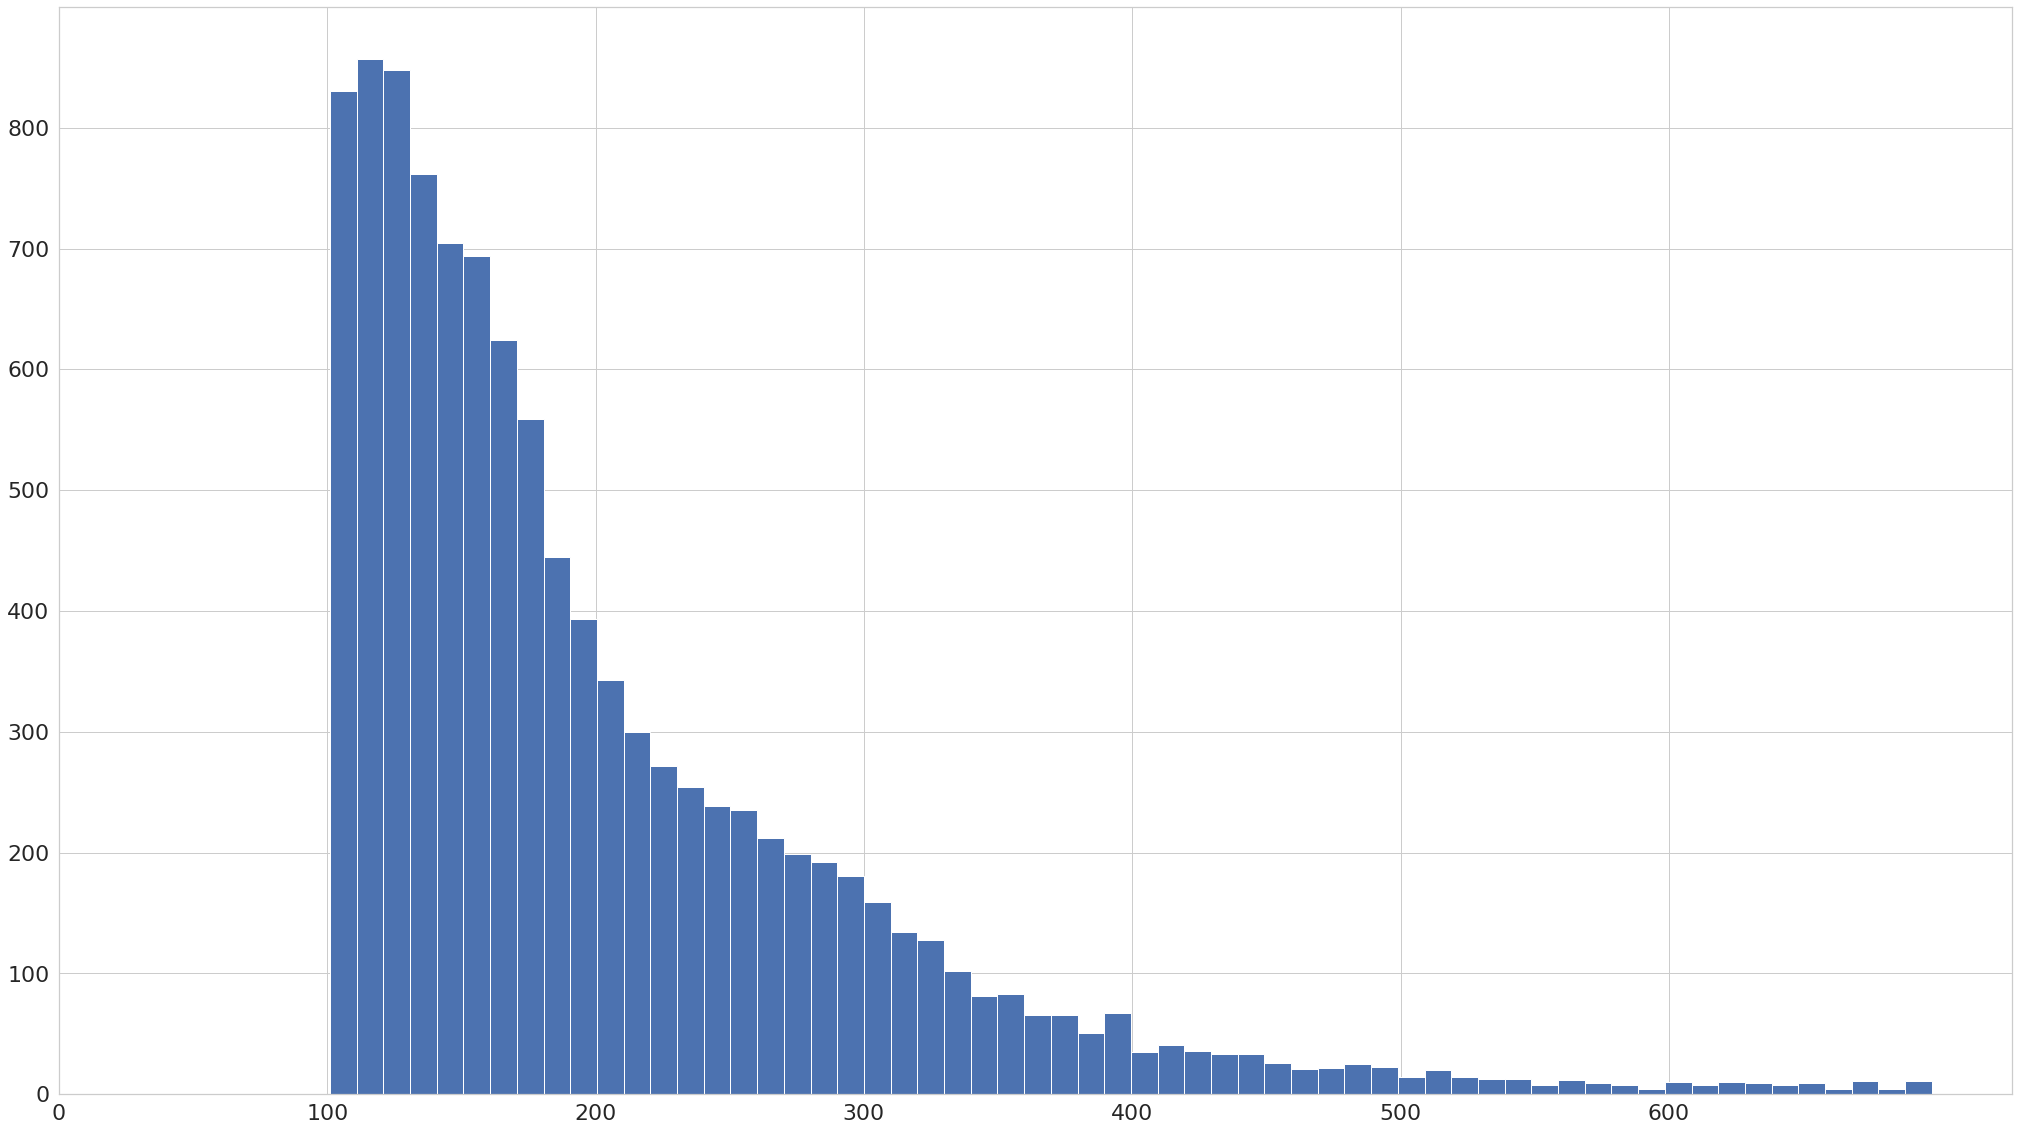

In [162]:
acc_df_concated = get_concated_df(acc_dir)
plot_lengths_hist(acc_df_concated['content'], xtick = np.arange(0,700,100))

In [163]:
acc_df_concated.loc[:, 'date'] = pd.to_datetime(acc_df_concated['date'])

In [164]:
acc_df_concated['content'].drop_duplicates(inplace = True)
acc_df_concated.drop_duplicates(inplace = True)

In [165]:
acc_df_concated = acc_df_concated.dropna()
acc_df_concated.isna().sum()

title      0
content    0
date       0
dtype: int64

In [166]:
acc_df_concated.loc[:, 'content'] = acc_df_concated['title'] + ' ' + acc_df_concated['content']
acc_df_concated = acc_df_concated.drop(columns = ['title'])

In [167]:
acc_df_concated.to_csv('/content/drive/MyDrive/VTB hack/acc_data_processed.csv')

## Графики

In [ ]:
def Get_pie_graph(dir_path, path_to_save_png):
  #рисуем график количества новостей для каждого сайта
  csv_s = [i for i in os.listdir(dir_path) if '.csv' in i]
  csv_paths = []
  for filename in csv_s:
    csv_paths.append(os.path.join(dir_path, filename))
  tg_mask = ['_tg' in i for i in csv_paths]

  shapes = []
  for i in csv_paths:
    df = pd.read_csv(i, index_col = [0])
    shapes.append(df.shape[0])
  df = pd.concat([pd.Series(csv_paths),pd.Series(shapes), pd.Series(csv_s).apply(lambda x: x[:x.find('_')]), pd.Series(tg_mask)], axis = 1)
  df.columns = ['full_path', 'news_amount', 'name', 'tg_mask']

  fig1, ax1 = plt.subplots(figsize=(16,9))
  colors = sns.color_palette('flare')[0:df.shape[0]]
  textprops = {'fontsize': 18, 'color': 'white'}
  ax1.pie(df.news_amount.values, startangle=90, colors = colors, center=(0, -2), textprops = textprops)
  ax1.axis('equal')  
  fig1.savefig(path_to_save_png, dpi=300, transparent=True)

In [ ]:
Get_pie_graph(ceo_dir, path_to_save_png = 'pie_для_директоров.png')
Get_pie_graph(acc_dir, path_to_save_png = 'pie_для_бухгалтеров.png')

In [192]:
def get_news_length_distrib_graph(df, name):
  lengths = df['content'].apply(lambda x: len(x.split()))
  step = 10
  stamp = np.arange(100,700,step)
  counts = list(map(lambda x: ((lengths >= x) & (lengths <= x + step)).sum(),stamp))
  counts = np.asarray(counts)
  stamp = stamp.astype(str)
  new_stamp = []
  for i in range(len(stamp)-1):
    new_stamp.append(stamp[i] +'-'+ stamp[i+1])

  new_stamp.append(stamp[len(stamp)-1] +'-'+ str(int(stamp[-1])+(step)))
  new_stamp = np.asarray(new_stamp)

  sns.set_theme(
    font_scale = 2,
    style = 'whitegrid', # ставит стиль графика, тут стоит белый с сеткой
    rc = {'figure.figsize' : (20, 7)}
  )
  plt.rcParams['font.size'] = '6'
  ax = sns.barplot(x = new_stamp, y = counts, palette=sns.color_palette("flare"))
  ax.tick_params(colors='white', labelsize = 15)
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, size = 12)
  plt.tight_layout()
  plt.savefig(f'{name}.png', dpi=300, transparent=True)



In [ ]:
get_news_length_distrib_graph(ceo_df_concated, 'ceo_news_length_disrib')
get_news_length_distrib_graph(acc_df_concated, 'accountant_news_length_disrib')